# Teste de viabilidade

**Caio Geraldes, 2021**

Este notebook testa a viabilidade dos algoritmos do módulo `lexicogenero`, de minha autoria, para selecionar, dividir e organizar dados de textos em prosa em grego antigo para a disciplina FLL5133-2021.
O código fonte dos scripts utilizados aqui, bem como dos testes de qualidade estão disponíveis em meu [GitHub](https://github.com/caiogeraldes/lexico-e-genero/).

## Carregamento e organização dos dados importados do Diorisis

Pretendo utilizar o corpus anotado [Diorisis](https://figshare.com/articles/dataset/The_Diorisis_Ancient_Greek_Corpus_JSON_/12251468) de Alessandro Vatri e Barbara McGillyvray, disponível em formato `.json` e com lemmatização confiável ([Vatri, 2020](https://brill.com/view/journals/jgl/20/2/article-p179_4.xml)).
 Para processar esse corpus, utilizei as funções criadas em [../src/lexicogenero/ferramentas/diorisis_reader.py](https://github.com/caiogeraldes/lexico-e-genero/blob/main/src/lexicogenero/ferramentas/diorisis_reader.py).
 A lista de *stop words* utilizada vem de [Rodda, 2020](https://github.com/MartinaAstridRodda/dphil-thesis), com algumas adições (código em [../src/lexicogenero/grc.py](https://github.com/caiogeraldes/lexico-e-genero/blob/main/src/lexicogenero/grc.py)).

In [88]:
import os
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split

In [89]:
from lexicogenero.ferramentas.diorisis_reader import carrega_textos, em_pandas, sent_pandas
from lexicogenero.main import DIORISIS_PATH
from lexicogenero.grc import STOPS_LIST

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]

Neste teste, usaremos como corpus os textos de historiografia e prosa filosófica (diálogos e tratados) de autores do período clássico:

- Historiografia:
    - Heródoto
    - Xenofonte:
        - Ciropédia
        - Anábase
        - Helênica
    - Tucídides
- Prosa filosófica:
    - Platão
    - Xenofonte:
        - Agesilau
        - Hierão
        - Simpósio
        - Apologia
        - Memorabilia

In [90]:
DATA = "data.csv"
SENTS = "sents.csv"
REAPROVEITAR = True

if not REAPROVEITAR or (DATA not in os.listdir() or SENTS not in os.listdir()):
    ignorados = [
        "Xenophon (0032) - On the Art of Horsemanship (013).json",
        "Xenophon (0032) - Economics (003).json",
        "Xenophon (0032) - Ways and Means (011).json",
        "Xenophon (0032) - Constitution of the Lacedaemonians (010).json",
        "Xenophon (0032) - On the Cavalry Commander (012).json",
        "Xenophon (0032) - On Hunting (014).json",
        "Xenophon (0032) - Apology (005).json",
        "Plato (0059) - Alcibiades 2 (014).json", # Anotação problemática
    ]

    corpus = carrega_textos(autores=['Herodotus', 
                                     'Thucydides', 
                                     'Plato', 
                                     'Xenophon (0032)', # Exclui Xenofonte de Éfeso 
                                     ],
                            diorisis_path=DIORISIS_PATH,
                            ignore=ignorados,
                            verbose=False)
    df_tokens = em_pandas(corpus)
    df_sents = sent_pandas(corpus)
    del corpus
    df_tokens.to_csv(DATA, index=False)
    df_sents.to_csv(SENTS, index=False)
        
else:
    print('Carregando dataframe previamente salvo')
    df_tokens = pd.read_csv(DATA)
    df_sents = pd.read_csv(SENTS)

Criando DF para: Herodotus (0016) - Histories (001).json
Criando DF para: Thucydides (0003) - History (001).json
Criando DF para: Plato (0059) - Cleitophon (029).json
Criando DF para: Plato (0059) - Menexenus (028).json
Criando DF para: Plato (0059) - Symposium (011).json
Criando DF para: Plato (0059) - Hipparchus (015).json
Criando DF para: Plato (0059) - Lovers (016).json
Criando DF para: Plato (0059) - Minos (033).json
Criando DF para: Plato (0059) - Phaedrus (012).json
Criando DF para: Plato (0059) - Epinomis (035).json
Criando DF para: Plato (0059) - Apology (002).json
Criando DF para: Plato (0059) - Protagoras (022).json
Criando DF para: Plato (0059) - Timaeus (031).json
Criando DF para: Plato (0059) - Hippias Minor (026).json
Criando DF para: Plato (0059) - Sophist (007).json
Criando DF para: Plato (0059) - Gorgias (023).json
Criando DF para: Plato (0059) - Laches (019).json
Criando DF para: Plato (0059) - Critias (032).json
Criando DF para: Plato (0059) - Euthyphro (001).json
C

**Formato do DF**: ainda não decidi se seria mais eficiente utilizar um data frame organizado por token ou por sentenças. A implementação de ambos é muito semelhante e pode ser vista em `../src/lexicogenero/ferramentas/diorisis_parser.py`

In [92]:
df_tokens.head()

,sent_id,location,form,lemma,POS,analyses,id,file,author,text
0,1,1.t.1,Ἡροδότου,Ἡρόδοτος,proper,masc gen sg,1,Herodotus (0016) - Histories (001).json,Herodotus,Histories
1,1,1.t.1,Ἁλικαρνησσέος,Ἁλικαρνησσεύς,proper,masc gen sg (epic ionic),2,Herodotus (0016) - Histories (001).json,Herodotus,Histories
2,1,1.t.1,ἱστορίης,ἱστορία,noun,fem gen sg (epic ionic),3,Herodotus (0016) - Histories (001).json,Herodotus,Histories
3,1,1.t.1,ἀπόδεξις,ἀπόδεξις,noun,fem nom sg,4,Herodotus (0016) - Histories (001).json,Herodotus,Histories
4,1,1.t.1,ἥδε,ὅδε,pronoun,fem nom sg,5,Herodotus (0016) - Histories (001).json,Herodotus,Histories


In [93]:
df_sents.head()

,sent_id,location,forms,lemmata,file,author,text
0,1,1.t.1,"Ἡροδότου Ἁλικαρνησσέος ἱστορίης ἀπόδεξις ἥδε ,...",Ἡρόδοτος Ἁλικαρνησσεύς ἱστορία ἀπόδεξις ὅδε ὡς...,Herodotus (0016) - Histories (001).json,Herodotus,Histories
1,2,1.1.1,Περσέων μέν νυν οἱ λόγιοι Φοίνικας αἰτίους φασ...,Πέρσευς μέν νῦν ὁ λόγιος Φοῖνιξ αἴτιος φημί γί...,Herodotus (0016) - Histories (001).json,Herodotus,Histories
2,3,1.1.2,τούτους γὰρ ἀπὸ τῆς Ἐρυθρῆς καλεομένης θαλάσση...,οὗτος γάρ ἀπό ὁ Ἐρυθραί καλέω θάλασσα ἀφικνέομ...,Herodotus (0016) - Histories (001).json,Herodotus,Histories
3,4,1.1.7,τὸ δὲ Ἄργος τοῦτον τὸν χρόνον προεῖχε ἅπασι τῶ...,ὁ δέ Ἄργος οὗτος ὁ χρόνος προέχω ἅπας ὁ ἐν ὁ ν...,Herodotus (0016) - Histories (001).json,Herodotus,Histories
4,5,1.1.9,ἀπικομένους δὲ τούς Φοίνικας ἐς δὴ τὸ Ἄργος το...,ἀφικνέομαι δέ ὁ Φοῖνιξ εἰς δή ὁ Ἄργος οὗτος δι...,Herodotus (0016) - Histories (001).json,Herodotus,Histories


## Anotando Gênero

In [94]:
hist = [
    "Herodotus (0016) - Histories (001).json",
    "Thucydides (0003) - History (001).json",
    "Xenophon (0032) - Hellenica (001).json",
    "Xenophon (0032) - Cyropaedia (007).json",
    "Xenophon (0032) - Anabasis (006).json",
]

In [95]:
# Deve haver uma maneira menos rocambolesca para resolver isso
df_tokens['genero'] = np.nan
df_tokens.loc[df_tokens.file.isin(hist), 'genero'] = "hist"
df_tokens.genero.fillna("filo", inplace=True)
df_sents['genero'] = np.nan
df_sents.loc[df_sents.file.isin(hist), 'genero'] = "hist"
df_sents.genero.fillna("filo", inplace=True)

Para meu modelo funcionar, será necessário ter uma quantidade relativamente equilibrada de dados entre autores de prosa historiográfica e prosa filosófica, a seleção parece razoável.
Qualquer tentativa de aumentar os dados de historiografia forçaria aumentar o escopo temporal (o próximo autor seria Políbio, já do período helenístico).
Nota-se que a diferença aumenta quando tratamos de sentenças e não de tokens, indicando que as sentenças em textos historiográficos devem ser um pouco mais longas na média.

<AxesSubplot:>

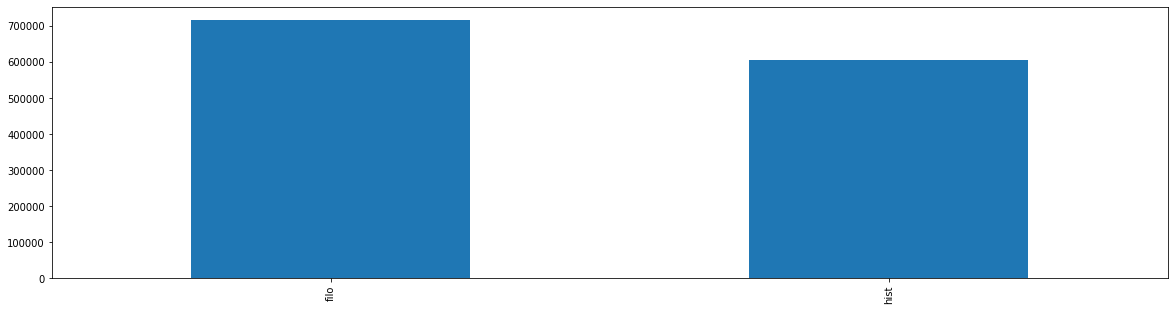

In [96]:
df_tokens.genero.value_counts().plot(kind='bar')

<AxesSubplot:>

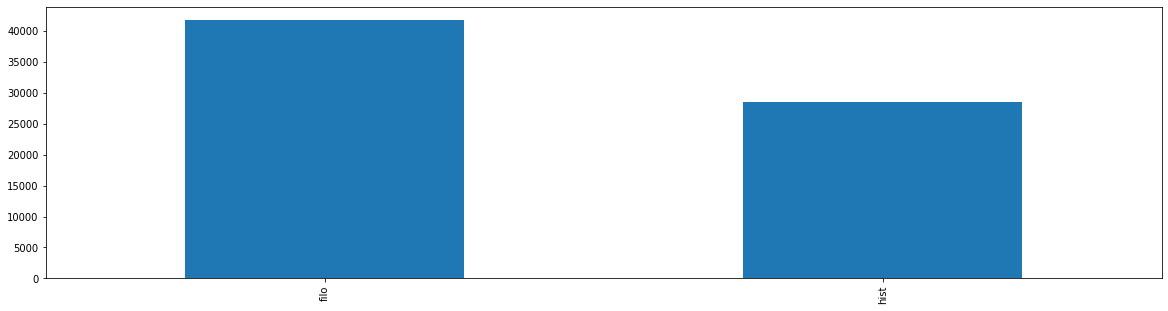

In [97]:
df_sents.genero.value_counts().plot(kind='bar')

## Verbos por gênero (dataframe de tokens)

In [98]:
df_verbos = df_tokens.loc[(df_tokens.POS == "verb") & (-df_tokens.lemma.isin(STOPS_LIST)),]
df_verbos.head()

,sent_id,location,form,lemma,POS,analyses,id,file,author,text,genero
30,1,1.t.1,ἀποδεχθέντα,ἀποδέχομαι,verb,aor part pass neut nom/voc/acc pl;aor part pas...,28,Herodotus (0016) - Histories (001).json,Herodotus,Histories,hist
42,1,1.t.1,ἐπολέμησαν,πολεμέω,verb,aor ind act 3rd pl,38,Herodotus (0016) - Histories (001).json,Herodotus,Histories,hist
62,3,1.1.2,καλεομένης,καλέω,verb,fut part mid fem gen sg (attic epic ionic);pre...,6,Herodotus (0016) - Histories (001).json,Herodotus,Histories,hist
64,3,1.1.2,ἀπικομένους,ἀφικνέομαι,verb,aor part mid masc acc pl (ionic),8,Herodotus (0016) - Histories (001).json,Herodotus,Histories,hist
71,3,1.1.2,οἰκήσαντας,οἰκέω,verb,aor part act masc acc pl,14,Herodotus (0016) - Histories (001).json,Herodotus,Histories,hist


A filtragem não causa mudança na proporção entre documentos de historiografia e filosofia.

<AxesSubplot:>

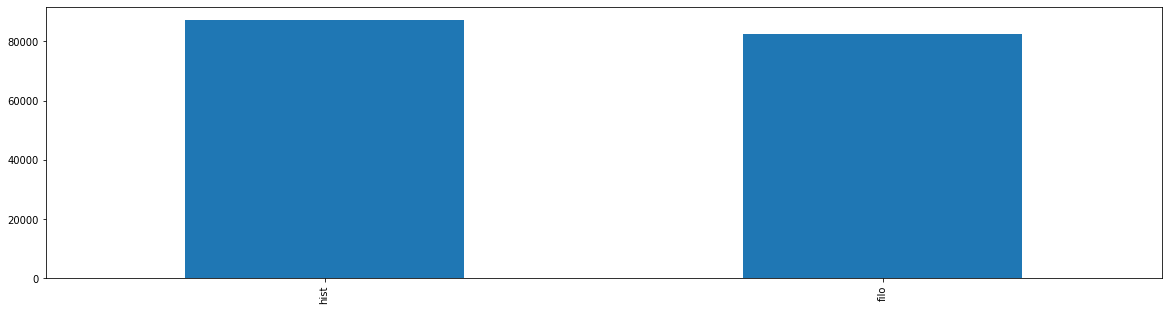

In [99]:
df_verbos.genero.value_counts().plot(kind='bar')

In [100]:
filo_verbos = df_verbos[df_verbos.genero == "filo"].lemma
filo_verbos.value_counts()

οἴομαι          1728
οἶδα            1451
φαίνω           1198
βούλομαι        1163
δεῖ             1017
                ... 
ἀνακάμπτω          1
μαλακίζομαι        1
ἐναντιολογέω       1
παρωνυμέω          1
ἐφέζομαι           1
Name: lemma, Length: 3652, dtype: int64

<AxesSubplot:ylabel='Density'>

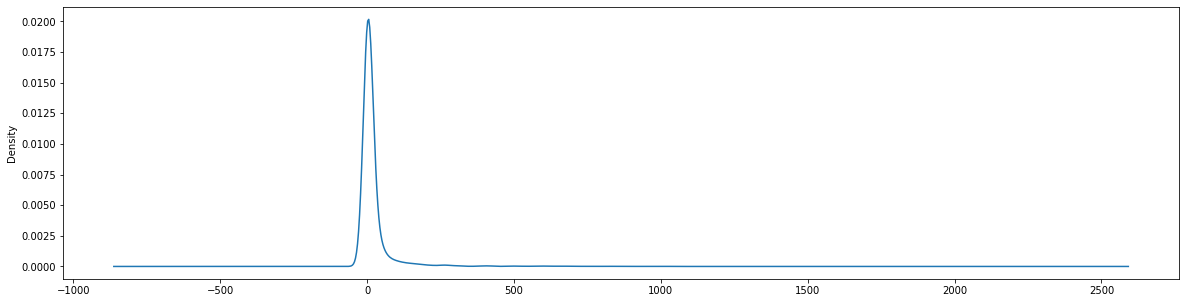

In [101]:
filo_verbos.value_counts().plot(kind='density')

In [102]:
hist_verbos = df_verbos[df_verbos.genero == "hist"].lemma
hist_verbos.value_counts()

βούλομαι        1177
λαμβάνω          994
ἀφικνέομαι       915
ἔρχομαι          872
πάρειμι          822
                ... 
ἐπεικάζω           1
ἀποκηδεύω          1
πυκνόω             1
καθιππάζομαι       1
ἐξαυλίζομαι        1
Name: lemma, Length: 4331, dtype: int64

<AxesSubplot:ylabel='Density'>

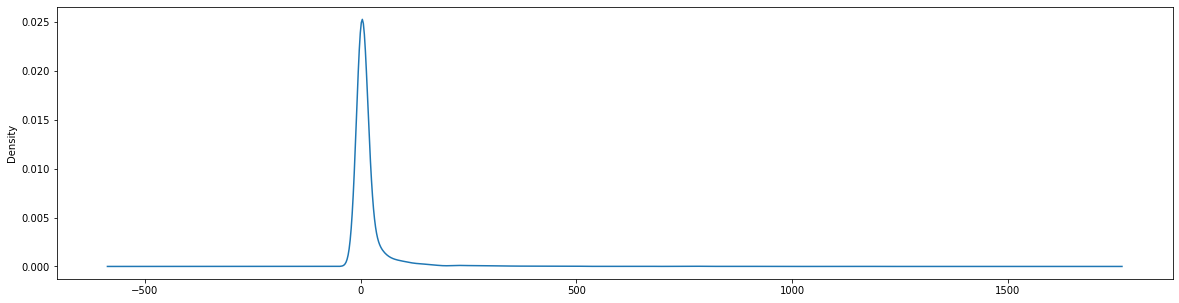

In [103]:
hist_verbos.value_counts().plot(kind='density')

## Naive Bayes


### Apenas de tokens

O resultado é terrível, provavelmente porque a implementação do modelo não é a melhor, afinal o `DOCUMENTO` e suas componentes são a mesma entidade.

In [104]:
x, y = df_verbos.lemma, df_verbos.genero

In [105]:

x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size=0.20, random_state=42)

filo = [x for x, y in zip(x_treino, y_treino) if y == 'filo']
hist = [x for x, y in zip(x_treino, y_treino) if y == 'hist']

In [106]:
vocab_filo = Counter(filo)
vocab_hist = Counter(hist)

In [107]:
n_filo = len(filo)
n_hist = len(hist)
n = n_filo + n_hist
p_filo = np.log2(n_filo / n)
p_hist = np.log2(n_hist / n)

In [108]:
n_vocab_filo = len(vocab_filo)
n_vocab_hist = len(vocab_hist)

In [109]:
def bayes(texto):
    
    texto_filo = [x for x in texto if x in vocab_filo.keys()]
    c_doc_filo = Counter(texto_filo)
    texto_hist = [x for x in texto if x in vocab_hist.keys()]
    c_doc_hist = Counter(texto_hist)
    
    pf_filo = sum([np.log2((c_doc_filo[token] + 1) / n_vocab_filo + len(texto_filo)) for token in texto_filo])
    pf_hist = sum([np.log2((c_doc_hist[token] + 1) / n_vocab_hist + len(texto_hist)) for token in texto_hist])

    
    prob_filo = p_filo + pf_filo
    prob_hist = p_hist + pf_hist


    return prob_filo, prob_hist

In [110]:
teste_pred_labels = []
for t in x_teste:
    prob_filo, prob_hist = bayes(t)
    if prob_filo >= prob_hist:
        teste_pred_labels.append("filo")
    else:
        teste_pred_labels.append("hist")

In [111]:
teste_orig_labels = [x for x in y_teste]

performance_labels = []

for pred, label in zip(teste_pred_labels, teste_orig_labels):
    if label == "filo" and pred == "filo":
        performance_labels.append("VP")
    elif label == "filo" and pred == "hist":
        performance_labels.append("FP")
    elif label == "hist" and pred == "hist":
        performance_labels.append("VN")
    else:
        performance_labels.append("FN")
        
perf_counter = Counter(performance_labels)

In [112]:
perf_counter

Counter({'VN': 17311, 'FP': 16684})

### Com sentenças

O modelo assim performa melhor, mas é pouco específico para os meus interesses: que o vocabulário da prosa filosófica e historiográfica são distintos diz pouco sobre sua seleção de verbos.

In [113]:
def achatar(lista):
    return list(itertools.chain(*lista))

df_sents['lst_lemmata'] = df_sents.lemmata.str.split()
df_sents.dropna(inplace=True)

In [114]:
x, y = df_sents.lst_lemmata, df_sents.genero

x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size=0.20, random_state=42)

In [115]:
filo = [x for x, y in zip(x_treino, y_treino) if y == 'filo']
hist = [x for x, y in zip(x_treino, y_treino) if y == 'hist']

vocab_filo = Counter([x for x in achatar(filo)])
vocab_hist = Counter([x for x in achatar(hist)])

n_filo = len(filo)
n_hist = len(hist)
n = n_filo + n_hist
p_filo = np.log2(n_filo / n)
p_hist = np.log2(n_hist / n)

n_vocab_filo = len(vocab_filo)
n_vocab_hist = len(vocab_hist)

In [116]:
def bayes(texto):
    
    texto_filo = [x for x in texto if x in vocab_filo.keys()]
    c_doc_filo = Counter(texto_filo)
    texto_hist = [x for x in texto if x in vocab_hist.keys()]
    c_doc_hist = Counter(texto_hist)
    
    pf_filo = sum([np.log2((c_doc_filo[token] + 1) / n_vocab_filo + len(texto_filo)) for token in texto_filo])
    pf_hist = sum([np.log2((c_doc_hist[token] + 1) / n_vocab_hist + len(texto_hist)) for token in texto_hist])

    
    prob_filo = p_filo + pf_filo
    prob_hist = p_hist + pf_hist


    return prob_filo, prob_hist

In [117]:
teste_pred_labels = []
for t in x_teste:
    prob_filo, prob_hist = bayes(t)
    if prob_filo >= prob_hist:
        teste_pred_labels.append("filo")
    else:
        teste_pred_labels.append("hist")

teste_orig_labels = [x for x in y_teste]

In [118]:
performance_labels = []

for pred, label in zip(teste_pred_labels, teste_orig_labels):
    if label == "filo" and pred == "filo":
        performance_labels.append("VP")
    elif label == "filo" and pred == "hist":
        performance_labels.append("FP")
    elif label == "hist" and pred == "hist":
        performance_labels.append("VN")
    else:
        performance_labels.append("FN")

In [119]:
perf_counter = Counter(performance_labels)

perf_counter

Counter({'VN': 2716, 'VP': 8261, 'FN': 2943, 'FP': 157})

In [120]:
precisao = perf_counter['VP'] / (perf_counter['VP'] + perf_counter['FP'])
cobertura = perf_counter['VP'] / (perf_counter['VP'] + perf_counter['FN'])
acuracia = (perf_counter['VP'] + perf_counter['VN']) / len(performance_labels)
medida_f = 2 * (precisao * cobertura) / (precisao + cobertura)

print(f'Precisão:  {precisao}')
print(f'Cobertura: {cobertura}')
print(f'Acurácia:  {acuracia}')
print(f'Medida F:  {medida_f}')

Precisão:  0.9813494891898313
Cobertura: 0.7373259550160657
Acurácia:  0.779782624138666
Medida F:  0.8420140658444601


# Conclusões

- O banco de dados anotado Diorisis oferece as anotações necessárias e é relativamente fácil de processar.
- O corpus proposto oferece um número relativamente equilibrado de dados para as categorias a serem classificadas e o algoritmo de processamento permite que ele seja expandido conforme necessário.
- Será importante revisar a suavização utilizada (no caso Laplace) para poder obter um modelo funcional se for utilizado um modelo como o Naive Bayes apenas com os verbos, embora a princípio já seja possível afirmar que esse modelo não funcionará bem assim.
- Se for possível codificar a informação de `df_sents.lst_lemmata` selecionar os verbos principais (utilizando o dependency parser do `stanza-perseus`), os resultados poderão ser mais consistentes com aqueles que são de meu interesse.

# Outra abordagem

Testando os exemplos por meio de agrupamento em parágrafos:

In [121]:
df_tokens[['div_sup', 'par']] = df_tokens.location.str.split('.', n=1, expand=True)

In [122]:
df_tokens.dropna(inplace=True)

In [123]:
j = df_tokens.groupby(['author', 'text', 'file','div_sup', 'par', 'genero']).agg({
    'lemma': lambda x: " ".join(x),
})

In [124]:
df_tokens_par = j.reset_index()

In [125]:
df_tokens_par

,author,text,file,div_sup,par,genero,lemma
0,Herodotus,Histories,Herodotus (0016) - Histories (001).json,1,1.1,hist,Πέρσευς μέν νῦν ὁ λόγιος Φοῖνιξ αἴτιος φημί γί...
1,Herodotus,Histories,Herodotus (0016) - Histories (001).json,1,1.13,hist,"ὁ δέ ὁ ὄνομα εἰμί , κατά αὐτός ὁ καί Ἕλλην λέγ..."
2,Herodotus,Histories,Herodotus (0016) - Histories (001).json,1,1.14,hist,οὗτος ἵστημι κατά πρύμνα ὁ ναῦς ὠνέομαι ὁ φορτ...
3,Herodotus,Histories,Herodotus (0016) - Histories (001).json,1,1.17,hist,"ὁ μέν δή πλείων ὁ γυνή ἀποφεύγω , ὁ δέ Ἰώ σύν ..."
4,Herodotus,Histories,Herodotus (0016) - Histories (001).json,1,1.19,hist,εἰσβάλλω δέ εἰς ὁ ναῦς οἴχομαι ἀποπλέω ἐπί Αἴγ...
...,...,...,...,...,...,...,...
56301,Xenophon,Symposium,Xenophon (0032) - Symposium (004).json,9,6.1,filo,ἄν ; καί γάρ ἀκούω ὁ Διόνυσος μέν ἐπερωτάω αὐτ...
56302,Xenophon,Symposium,Xenophon (0032) - Symposium (004).json,9,6.5,filo,ἔοικα γάρ οὐ διδάσκω ὁ σχῆμα ἀλλά ἐφέζομαι πρά...
56303,Xenophon,Symposium,Xenophon (0032) - Symposium (004).json,9,7.1,filo,τέλος δέ ὁ συμπότης εἶδον περιβάλλω τε ἀλλήλων...
56304,Xenophon,Symposium,Xenophon (0032) - Symposium (004).json,9,7.4,filo,Σωκράτης δέ καί ὁ ἄλλος ὁ ὑπομένω πρός Λύκων κ...


<AxesSubplot:>

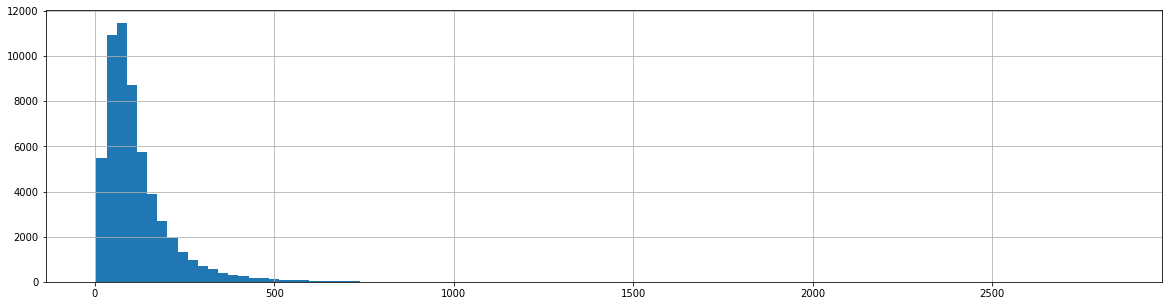

In [126]:
df_tokens_par.lemma.apply(len).hist(grid=True, bins=100)

In [127]:
minimo, maximo = df_tokens_par.lemma.apply(len).quantile([.05, .95]).values
tamanho_representativo = (df_tokens_par.lemma.apply(len) > minimo) & (df_tokens_par.lemma.apply(len) < maximo)

In [128]:
df_tokens_par.loc[tamanho_representativo]

,author,text,file,div_sup,par,genero,lemma
0,Herodotus,Histories,Herodotus (0016) - Histories (001).json,1,1.1,hist,Πέρσευς μέν νῦν ὁ λόγιος Φοῖνιξ αἴτιος φημί γί...
1,Herodotus,Histories,Herodotus (0016) - Histories (001).json,1,1.13,hist,"ὁ δέ ὁ ὄνομα εἰμί , κατά αὐτός ὁ καί Ἕλλην λέγ..."
2,Herodotus,Histories,Herodotus (0016) - Histories (001).json,1,1.14,hist,οὗτος ἵστημι κατά πρύμνα ὁ ναῦς ὠνέομαι ὁ φορτ...
3,Herodotus,Histories,Herodotus (0016) - Histories (001).json,1,1.17,hist,"ὁ μέν δή πλείων ὁ γυνή ἀποφεύγω , ὁ δέ Ἰώ σύν ..."
4,Herodotus,Histories,Herodotus (0016) - Histories (001).json,1,1.19,hist,εἰσβάλλω δέ εἰς ὁ ναῦς οἴχομαι ἀποπλέω ἐπί Αἴγ...
...,...,...,...,...,...,...,...
56301,Xenophon,Symposium,Xenophon (0032) - Symposium (004).json,9,6.1,filo,ἄν ; καί γάρ ἀκούω ὁ Διόνυσος μέν ἐπερωτάω αὐτ...
56302,Xenophon,Symposium,Xenophon (0032) - Symposium (004).json,9,6.5,filo,ἔοικα γάρ οὐ διδάσκω ὁ σχῆμα ἀλλά ἐφέζομαι πρά...
56303,Xenophon,Symposium,Xenophon (0032) - Symposium (004).json,9,7.1,filo,τέλος δέ ὁ συμπότης εἶδον περιβάλλω τε ἀλλήλων...
56304,Xenophon,Symposium,Xenophon (0032) - Symposium (004).json,9,7.4,filo,Σωκράτης δέ καί ὁ ἄλλος ὁ ὑπομένω πρός Λύκων κ...


In [129]:
def achatar(lista):
    return list(itertools.chain(*lista))

df_tokens_par['lst_lemmata'] = df_tokens_par.lemma.str.split()
df_tokens_par

,author,text,file,div_sup,par,genero,lemma,lst_lemmata
0,Herodotus,Histories,Herodotus (0016) - Histories (001).json,1,1.1,hist,Πέρσευς μέν νῦν ὁ λόγιος Φοῖνιξ αἴτιος φημί γί...,"[Πέρσευς, μέν, νῦν, ὁ, λόγιος, Φοῖνιξ, αἴτιος,..."
1,Herodotus,Histories,Herodotus (0016) - Histories (001).json,1,1.13,hist,"ὁ δέ ὁ ὄνομα εἰμί , κατά αὐτός ὁ καί Ἕλλην λέγ...","[ὁ, δέ, ὁ, ὄνομα, εἰμί, ,, κατά, αὐτός, ὁ, καί..."
2,Herodotus,Histories,Herodotus (0016) - Histories (001).json,1,1.14,hist,οὗτος ἵστημι κατά πρύμνα ὁ ναῦς ὠνέομαι ὁ φορτ...,"[οὗτος, ἵστημι, κατά, πρύμνα, ὁ, ναῦς, ὠνέομαι..."
3,Herodotus,Histories,Herodotus (0016) - Histories (001).json,1,1.17,hist,"ὁ μέν δή πλείων ὁ γυνή ἀποφεύγω , ὁ δέ Ἰώ σύν ...","[ὁ, μέν, δή, πλείων, ὁ, γυνή, ἀποφεύγω, ,, ὁ, ..."
4,Herodotus,Histories,Herodotus (0016) - Histories (001).json,1,1.19,hist,εἰσβάλλω δέ εἰς ὁ ναῦς οἴχομαι ἀποπλέω ἐπί Αἴγ...,"[εἰσβάλλω, δέ, εἰς, ὁ, ναῦς, οἴχομαι, ἀποπλέω,..."
...,...,...,...,...,...,...,...,...
56301,Xenophon,Symposium,Xenophon (0032) - Symposium (004).json,9,6.1,filo,ἄν ; καί γάρ ἀκούω ὁ Διόνυσος μέν ἐπερωτάω αὐτ...,"[ἄν, ;, καί, γάρ, ἀκούω, ὁ, Διόνυσος, μέν, ἐπε..."
56302,Xenophon,Symposium,Xenophon (0032) - Symposium (004).json,9,6.5,filo,ἔοικα γάρ οὐ διδάσκω ὁ σχῆμα ἀλλά ἐφέζομαι πρά...,"[ἔοικα, γάρ, οὐ, διδάσκω, ὁ, σχῆμα, ἀλλά, ἐφέζ..."
56303,Xenophon,Symposium,Xenophon (0032) - Symposium (004).json,9,7.1,filo,τέλος δέ ὁ συμπότης εἶδον περιβάλλω τε ἀλλήλων...,"[τέλος, δέ, ὁ, συμπότης, εἶδον, περιβάλλω, τε,..."
56304,Xenophon,Symposium,Xenophon (0032) - Symposium (004).json,9,7.4,filo,Σωκράτης δέ καί ὁ ἄλλος ὁ ὑπομένω πρός Λύκων κ...,"[Σωκράτης, δέ, καί, ὁ, ἄλλος, ὁ, ὑπομένω, πρός..."


In [130]:
x, y = df_tokens_par.lst_lemmata, df_tokens_par.genero

x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size=0.20, random_state=42)
filo = [x for x, y in zip(x_treino, y_treino) if y == 'filo']
hist = [x for x, y in zip(x_treino, y_treino) if y == 'hist']

vocab_filo = Counter([x for x in achatar(filo)])
vocab_hist = Counter([x for x in achatar(hist)])

n_filo = len(filo)
n_hist = len(hist)
n = n_filo + n_hist
p_filo = np.log2(n_filo / n)
p_hist = np.log2(n_hist / n)

n_vocab_filo = len(vocab_filo)
n_vocab_hist = len(vocab_hist)

teste_pred_labels = []
for t in x_teste:
    prob_filo, prob_hist = bayes(t)
    if prob_filo >= prob_hist:
        teste_pred_labels.append("filo")
    else:
        teste_pred_labels.append("hist")

teste_orig_labels = [x for x in y_teste]

performance_labels = []

for pred, label in zip(teste_pred_labels, teste_orig_labels):
    if label == "filo" and pred == "filo":
        performance_labels.append("VP")
    elif label == "filo" and pred == "hist":
        performance_labels.append("FP")
    elif label == "hist" and pred == "hist":
        performance_labels.append("VN")
    else:
        performance_labels.append("FN")

perf_counter = Counter(performance_labels)

perf_counter

precisao = perf_counter['VP'] / (perf_counter['VP'] + perf_counter['FP'])
cobertura = perf_counter['VP'] / (perf_counter['VP'] + perf_counter['FN'])
acuracia = (perf_counter['VP'] + perf_counter['VN']) / len(performance_labels)
medida_f = 2 * (precisao * cobertura) / (precisao + cobertura)

print(f'Precisão:  {precisao}')
print(f'Cobertura: {cobertura}')
print(f'Acurácia:  {acuracia}')
print(f'Medida F:  {medida_f}')

Precisão:  0.9732654360280076
Cobertura: 0.7165787932044523
Acurácia:  0.7702894690108328
Medida F:  0.8254268169242188


In [131]:
df_verbos[['div_sup', 'par']] = df_verbos.location.str.split('.', n=1, expand=True)

j = df_verbos.groupby(['author', 'text', 'file','div_sup', 'par', 'genero']).agg({
    'lemma': lambda x: " ".join(x),
})

df_verbos_par = j.reset_index()

/home/silenus/.cache/pypoetry/virtualenvs/lexicogenero-bQoba9Ka-py3.9/lib/python3.9/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [132]:
df_verbos_par['lst_lemmata'] = df_verbos_par.lemma.str.split()
df_verbos_par

x, y = df_verbos_par.lst_lemmata, df_verbos_par.genero

x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size=0.20)
filo = [x for x, y in zip(x_treino, y_treino) if y == 'filo']
hist = [x for x, y in zip(x_treino, y_treino) if y == 'hist']

vocab_filo = Counter([x for x in achatar(filo)])
vocab_hist = Counter([x for x in achatar(hist)])

n_filo = len(filo)
n_hist = len(hist)
n = n_filo + n_hist
p_filo = np.log2(n_filo / n)
p_hist = np.log2(n_hist / n)

n_vocab_filo = len(vocab_filo)
n_vocab_hist = len(vocab_hist)

teste_pred_labels = []
for t in x_teste:
    prob_filo, prob_hist = bayes(t)
    if prob_filo >= prob_hist:
        teste_pred_labels.append("filo")
    else:
        teste_pred_labels.append("hist")

teste_orig_labels = [x for x in y_teste]

performance_labels = []

for pred, label in zip(teste_pred_labels, teste_orig_labels):
    if label == "filo" and pred == "filo":
        performance_labels.append("VP")
    elif label == "filo" and pred == "hist":
        performance_labels.append("FP")
    elif label == "hist" and pred == "hist":
        performance_labels.append("VN")
    else:
        performance_labels.append("FN")

perf_counter = Counter(performance_labels)

perf_counter

precisao = perf_counter['VP'] / (perf_counter['VP'] + perf_counter['FP'])
cobertura = perf_counter['VP'] / (perf_counter['VP'] + perf_counter['FN'])
acuracia = (perf_counter['VP'] + perf_counter['VN']) / len(performance_labels)
medida_f = 2 * (precisao * cobertura) / (precisao + cobertura)

print(f'Precisão:  {precisao}')
print(f'Cobertura: {cobertura}')
print(f'Acurácia:  {acuracia}')
print(f'Medida F:  {medida_f}')

Precisão:  0.9846184982797005
Cobertura: 0.5630787037037037
Acurácia:  0.5981006053016071
Medida F:  0.716442088211472


In [142]:
texto_teste = "Ἡροδότου Ἁλικαρνησσέος ἱστορίης ἀπόδεξις ἥδε ὡς μήτε τὰ γενόμενα ἐξ ἀνθρώπων τῷ χρόνῳ ἐξίτηλα γένηται μήτε ἔργα μεγάλα τε καὶ θωμαστά τὰ μὲν Ἕλλησι τὰ δὲ βαρβάροισι ἀποδεχθέντα ἀκλεᾶ γένηται τά τε ἄλλα καὶ δι' ἣν αἰτίην ἐπολέμησαν ἀλλήλοισι"

In [143]:
import stanza
stanza.download('grc', package='perseus')

In [144]:
nlp_perseus = stanza.Pipeline(lang='grc', package='perseus', processors='tokenize,lemma', verbose=False)
doc_perseus = nlp_perseus(texto_teste)

In [145]:
nlp_proiel = stanza.Pipeline(lang='grc', package='proiel', processors='tokenize,lemma', verbose=False)
doc_proiel = nlp_proiel(texto_teste)

In [146]:
np.array(doc_perseus.get('lemma'))

array(['Ἡροδότης', 'Ἁλικαρνησσής', 'ἱστορίη', 'ἀπόδεξις', 'ὅδε', 'ὡς',
       'μήτε', 'ὁ', 'γίγνομαι', 'ἐκ', 'ἄνθρωπος', 'ὁ', 'χρόνος',
       'ἐξίτηλα', 'γίγνομαι', 'μήτε', 'ἔργον', 'μέγας', 'τε', 'καί',
       'θωμαίστα', 'ὁ', 'μέν', 'Ἕλλην', 'ὁ', 'δέ', 'βάρβαρος',
       'ἀποδεχθέντα', 'ἀκλεᾶ', 'γίγνομαι', 'ὁ', 'τε', 'ἄλλος', 'καί',
       "δι'", 'ὅς', 'αἰτία', 'πολεμέω', 'ἀλλήλων'], dtype='<U12')

In [147]:
np.array(doc_proiel.get('lemma'))

array(['Ἡρόδοτος', 'Ἁλικαρνασσεύς', 'ἱστορία', 'ἀπόδειξις', 'ὅδε', 'ὡς',
       'μήτε', 'ὁ', 'γίγνομαι', 'ἐκ', 'ἄνθρωπος', 'ὁ', 'χρόνος',
       'ἐξίτηλος', 'γίγνομαι', 'μήτε', 'ἔργον', 'μέγας', 'τε', 'καί',
       'θαυμαστός', 'ὁ', 'μέν', 'Ἕλλην', 'ὁ', 'δέ', 'βάρβαρος',
       'ἀποδείκνυμι', 'ἀκλεής', 'γίγνομαι', 'ὁ', 'τε', 'ἄλλος', 'καί',
       "δι'", 'ὅς', 'αἰτία', 'πολεμέω', 'ἀλλήλων'], dtype='<U13')

In [161]:
from cltk import NLP
cltk_nlp = NLP('grc')

‎𐤀 CLTK version '1.0.21'.
Pipeline for language 'Ancient Greek' (ISO: 'grc'): `GreekNormalizeProcess`, `GreekStanzaProcess`, `GreekEmbeddingsProcess`, `StopsProcess`, `GreekNERProcess`.


In [162]:
text = """
Ἡροδότου Ἁλικαρνησσέος ἱστορίης ἀπόδεξις ἥδε
ὡς μήτε τὰ γενόμενα ἐξ ἀνθρώπων τῷ χρόνῳ ἐξίτηλα γένηται 
μήτε ἔργα μεγάλα τε καὶ θωμαστά τὰ μὲν Ἕλλησι τὰ δὲ βαρβάροισι
ἀποδεχθέντα ἀκλεᾶ γένηται τά τε ἄλλα καὶ δι' ἣν αἰτίην ἐπολέμησαν ἀλλήλοισι.

Περσέων μέν νυν οἱ λόγιοι Φοίνικας αἰτίους φασὶ γενέσθαι τῆς διαφορῆς.
τούτους γὰρ ἀπὸ τῆς Ἐρυθρῆς καλεομένης θαλάσσης ἀπικομένους ἐπὶ τήνδε
τὴν θάλασσαν, καὶ οἰκήσαντας τοῦτον τὸν χῶρον τὸν καὶ νῦν οἰκέουσι,
αὐτίκα ναυτιλίῃσι μακρῇσι ἐπιθέσθαι, ἀπαγινέοντας δὲ φορτία Αἰγύπτιά
τε καὶ Ἀσσύρια τῇ τε ἄλλῃ ἐσαπικνέεσθαι καὶ δὴ καὶ ἐς Ἄργος. 
"""

In [163]:
doc_normalized = cltk_nlp.analyze(text)
print(doc_normalized.lemmata)

['Ἡρόδατος', 'Ἁλικαρνασσεῖς', 'ἱστορεή', 'ἀπήδειξις', 'ὅδε', 'ὡς', 'μήτε', 'ὁ', 'γίγνομαι', 'ἐκ', 'ἄνθρωπος', 'ὁ', 'χρόνῳ', 'ἐξίτηλος', 'γίγνομαι', 'μήτε', 'ἔργον', 'μέγας', 'τε', 'καί', 'θαυμαστός', 'ὁ', 'μέν', 'Ἕλλην', 'ὁ', 'δέ', 'βάρβερος', 'ἀποδείκνυμι', 'ἀκλεής', 'γίγνομαι', 'ὁ', 'τε', 'ἄλλος', 'καί', "δι'", 'ὅς', 'αἰτίην', 'πολεμέω', 'ἀλλήλοισι.', 'Πέρσιος', 'μέν', 'νυν', 'ὁ', 'λήγιος', 'Φοῖνιξ', 'αἰτῷον', 'φημί', 'γίγνομαι', 'ὁ', 'διαφορά', 'οὗτος', 'γάρ', 'ἀπό', 'ὁ', 'ἐρυθρός', 'καλεομένης', 'θάλεσσα', 'ἀπικόμανος', 'ἐπί', 'ὅδε', 'ὁ', 'θάλασσαν,', 'καί', 'οἰκέω', 'οὗτος', 'ὁ', 'χῶρος', 'ὁ', 'καί', 'νῦν', 'οἰκεύω', 'αὐτίκα', 'ναυτιλός', 'μακρός', 'ἐπιτίθημι', 'ἀπαγίγνομαι', 'δέ', 'φορτή', 'Αἰγύπτιά', 'τε', 'καί', 'Ἀσσήριος', 'ὁ', 'τε', 'ἄλλος', 'εἰσαφικνέομαι', 'καί', 'δή', 'καί', 'εἰς', 'Ἄργος', 'ἤ']


In [164]:
cltk_nlp.pipeline.processes.pop(0)

cltk.alphabet.processes.GreekNormalizeProcess

In [165]:
doc_not_normalized = cltk_nlp.analyze(text)
print(doc_not_normalized.lemmata)

['Ἡρόδοτος', 'Ἁλικαρνασσεύς', 'ἱστορία', 'ἀπόδειξις', 'ὅδε', 'ὡς', 'μήτε', 'ὁ', 'γίγνομαι', 'ἐκ', 'ἄνθρωπος', 'ὁ', 'χρόνος', 'ἐξίτηλος', 'γίγνομαι', 'μήτε', 'ἔργον', 'μέγας', 'τε', 'καί', 'θαυμαστός', 'ὁ', 'μέν', 'Ἕλλην', 'ὁ', 'δέ', 'βάρβαρος', 'ἀποδείκνυμι', 'ἀκλεής', 'γίγνομαι', 'ὁ', 'τε', 'ἄλλος', 'καί', "δι'", 'ὅς', 'αἰτία', 'πολεμέω', 'ἀλλήλωνσιος', 'Πέρσης', 'μέν', 'νυν', 'ὁ', 'λόγιος', 'Φοῖνιξ', 'αἴτιος', 'φημί', 'γίγνομαι', 'ὁ', 'διαφορά', 'οὗτος', 'γάρ', 'ἀπό', 'ὁ', 'ἐρυθρός', 'καλέω', 'θάλασσα', 'ἀφικνέομαι', 'ἐπί', 'ὅδε', 'ὁ', 'θάλασσα', 'καί', 'οἰκέω', 'οὗτος', 'ὁ', 'χῶρος', 'ὁ', 'καί', 'νῦν', 'οἰκέω', 'αὐτίκα', 'ναυτιλία', 'μακρός', 'ἐπιτίθημι', 'ἀπάγω', 'δέ', 'φορτίον', 'Αἰγύπτιος', 'τε', 'καί', 'Ἀσσύριος', 'ὁ', 'τε', 'ἄλλος', 'εἰσαφικνέομαι', 'καί', 'δή', 'καί', 'εἰς', 'Ἄργος', 'ἤ']


In [171]:
{token:(x, y) for token,x, y in zip(doc_normalized.tokens, doc_normalized.lemmata, doc_not_normalized.lemmata) if x != y}

{'Ἡροδότου': ('Ἡρόδατος', 'Ἡρόδοτος'),
 'Ἁλικαρνησσέος': ('Ἁλικαρνασσεῖς', 'Ἁλικαρνασσεύς'),
 'ἱστορίης': ('ἱστορεή', 'ἱστορία'),
 'ἀπόδεξις': ('ἀπήδειξις', 'ἀπόδειξις'),
 'μήτε': ('μήτε', 'μήτε'),
 'χρόνῳ': ('χρόνῳ', 'χρόνος'),
 'βαρβάροισι': ('βάρβερος', 'βάρβαρος'),
 'αἰτίην': ('αἰτίην', 'αἰτία'),
 'ἀλλήλοισι.': ('ἀλλήλοισι.', 'ἀλλήλωνσιος'),
 'Περσέων': ('Πέρσιος', 'Πέρσης'),
 'μέν': ('μέν', 'μέν'),
 'λόγιοι': ('λήγιος', 'λόγιος'),
 'αἰτίους': ('αἰτῷον', 'αἴτιος'),
 'καλεομένης': ('καλεομένης', 'καλέω'),
 'θαλάσσης': ('θάλεσσα', 'θάλασσα'),
 'ἀπικομένους': ('ἀπικόμανος', 'ἀφικνέομαι'),
 'θάλασσαν,': ('θάλασσαν,', 'θάλασσα'),
 'οἰκέουσι,': ('οἰκεύω', 'οἰκέω'),
 'αὐτίκα': ('αὐτίκα', 'αὐτίκα'),
 'ναυτιλίῃσι': ('ναυτιλός', 'ναυτιλία'),
 'ἀπαγινέοντας': ('ἀπαγίγνομαι', 'ἀπάγω'),
 'φορτία': ('φορτή', 'φορτίον'),
 'Αἰγύπτιά': ('Αἰγύπτιά', 'Αἰγύπτιος'),
 'Ἀσσύρια': ('Ἀσσήριος', 'Ἀσσύριος')}